To run the notebook, you must install skfeature:

`pip3 install skfeature-chappers`

To install skfeature-chapper.

In [1]:
import generate_data as gd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from skfeature.function.similarity_based import fisher_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

In [11]:
X,y = gd.gaussian_clusters(nr_features=20, nr_classes=200, \
                           nr_data_points=200, random_diag=True, variance_size=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

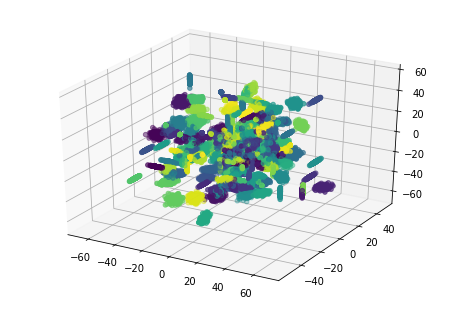

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0], X[:,1], X[:,2], c=y)
plt.show()

#### F-score

In [4]:
fscore = f_classif(X,y)
print(fscore)

(array([61854.19187642, 61776.37192527, 52165.39769372, 48795.88093409,
       60578.69547886, 59297.10534627, 53979.16232372, 67318.04697712,
       64657.20749822, 59583.23515346, 64706.1578758 , 63702.67909002,
       57250.7093525 , 53994.94697105, 60998.45766269, 67608.67114793,
       56579.86100232, 70921.9465844 , 73635.10442667, 60537.85481786]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]))


#### Mutual Information

In [5]:
mi = mutual_info_classif(X,y)
print(mi)

[3.24064171 3.12274832 3.07409866 3.08303135 3.21265799 3.14728285
 3.08540793 3.21606059 3.17860845 3.18712915 3.19926788 3.17013201
 3.11628704 3.06693207 3.11575065 3.2244486  3.17966098 3.19539648
 3.21414411 3.12350121]


#### Chi Squared

We need to normalize the data before using Chi Squared

In [6]:
scaler = MinMaxScaler()
scaler.fit(X)
X_normalized = scaler.transform(X)
chi = chi2(X_normalized,y)
print(chi)

(array([2815.75412698, 1988.9806195 , 2722.43802928, 2752.00120848,
       3019.02158916, 1500.98595469, 2277.01462808, 1998.68029347,
       2412.27490441, 2089.05274159, 2339.24142241, 2265.1196341 ,
       2723.08568098, 2080.58458863, 2267.09110476, 2492.39642706,
       3082.78429034, 2579.97458925, 2325.24946144, 1300.7801365 ]), array([0.00000000e+000, 2.72651125e-292, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 2.37711557e-198, 0.00000000e+000, 3.44530375e-294,
       0.00000000e+000, 6.35116674e-312, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 2.93843795e-310, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 5.44948276e-161]))


#### Fisher Score

In [7]:
#fisher = fisher_score.fisher_score(X,y)
#print(fisher)

## Filter Evaluation

### F-score

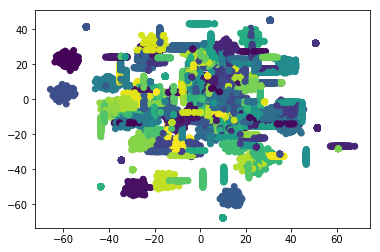

Unfiltered Score: 1.0, Filtered Score: 0.9046969696969697


In [13]:
X_fscore = SelectPercentile(f_classif, percentile=10).fit_transform(X, y)
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(
    X_fscore, y, test_size=0.33, random_state=42)

# Pruned data classifier
neigh = KNeighborsClassifier()
neigh.fit(X_fs_train, y_fs_train)
filtered_score = neigh.score(X_fs_test, y_fs_test)
plt.scatter(X_fs_train[:,0],X_fs_train[:,1], c=y_fs_train)
plt.show()

# Original data classifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
unfiltered_score = neigh.score(X_test, y_test)

print("Unfiltered Score: {}, Filtered Score: {}".format(unfiltered_score, filtered_score))

### Mutual Information

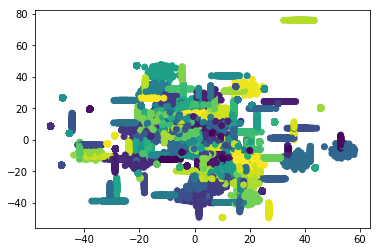

Unfiltered Score: 1.0, Filtered Score: 0.9146969696969697


In [14]:
X_mi = SelectPercentile(mutual_info_classif, percentile=10).fit_transform(X, y)
X_mi_train, X_mi_test, y_mi_train, y_mi_test = train_test_split(
    X_mi, y, test_size=0.33, random_state=42)

# Pruned data classifier
neigh = KNeighborsClassifier()
neigh.fit(X_mi_train, y_mi_train)
filtered_score = neigh.score(X_mi_test, y_mi_test)
plt.scatter(X_mi_train[:,0],X_mi_train[:,1], c=y_mi_train)
plt.show()

# Original data classifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
unfiltered_score = neigh.score(X_test, y_test)

print("Unfiltered Score: {}, Filtered Score: {}".format(unfiltered_score, filtered_score))

### Chi Square

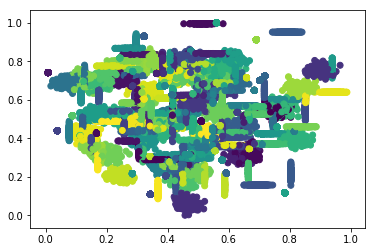

Unfiltered Score: 1.0, Filtered Score: 0.9025


In [15]:
scaler = MinMaxScaler()
scaler.fit(X)
# We need [0,1] for all values for chi2 to work
X_normalized = scaler.transform(X)

X_chi2 = SelectPercentile(chi2, percentile=10).fit_transform(X_normalized, y)
X_chi2_train, X_chi2_test, y_chi2_train, y_chi2_test = train_test_split(
    X_chi2, y, test_size=0.33, random_state=42)

# Pruned data classifier
neigh = KNeighborsClassifier()
neigh.fit(X_chi2_train, y_chi2_train)
filtered_score = neigh.score(X_chi2_test, y_chi2_test)
plt.scatter(X_chi2_train[:,0],X_chi2_train[:,1], c=y_chi2_train)
plt.show()

# Original data classifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
unfiltered_score = neigh.score(X_test, y_test)

print("Unfiltered Score: {}, Filtered Score: {}".format(unfiltered_score, filtered_score))